# 2. Mājasdarbs. Oļegs Korsaks 051RDB146
• Atrast datu kopu internetā. Piemēram no Awesomedata vai UCI Machine Learning

Repository vai citur

– Vēlams ar simtiem līdz tūkstošiem ierakstiem,

– Vēlams desmitiem atribūtiem,

– Skaitliskās vērtības atribūtos,

– Ar mērķa klasi/klasēm, bet var arī nepārtraukta vērtība,

– Dažām datu kopām var nebūt izvirzīta mērķa klase. Šādos gadījumos var izmantot vienu no atribūtiem par mērķa klasi (ja ir iespējams loģiski pamatot).

• Sadalīt datu kopu apmācības un testa kopās.

• Izveidot daudzslāņu mākslīgo neironu tīklu ar tensorflow un veikt apmācību.

• Aprēķināt un novērtēt apmācības un testa kopas kļūdu.

• Pamainīt tīkla konfigurāciju un novērtēt izmaiņu ietekmi

– Arhitektūru – slēpto slāņu skaits, neironu skaits slāņos,

– Aktivācijas funkcijas,

– Optimizācijas metodi.

In [213]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

sns.set_context('notebook', font_scale=2.0)
sns.set_style('darkgrid')

from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

## Datu ielāde

In [214]:
data = pd.read_csv('data/winequality-red.csv', sep=';')

### Datu analīze

In [215]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [217]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


## Datu vizualizācija un analīze

Paskatīsimies, vai ir dati, kuru vērtības ļoti atšķiras no vairuma.

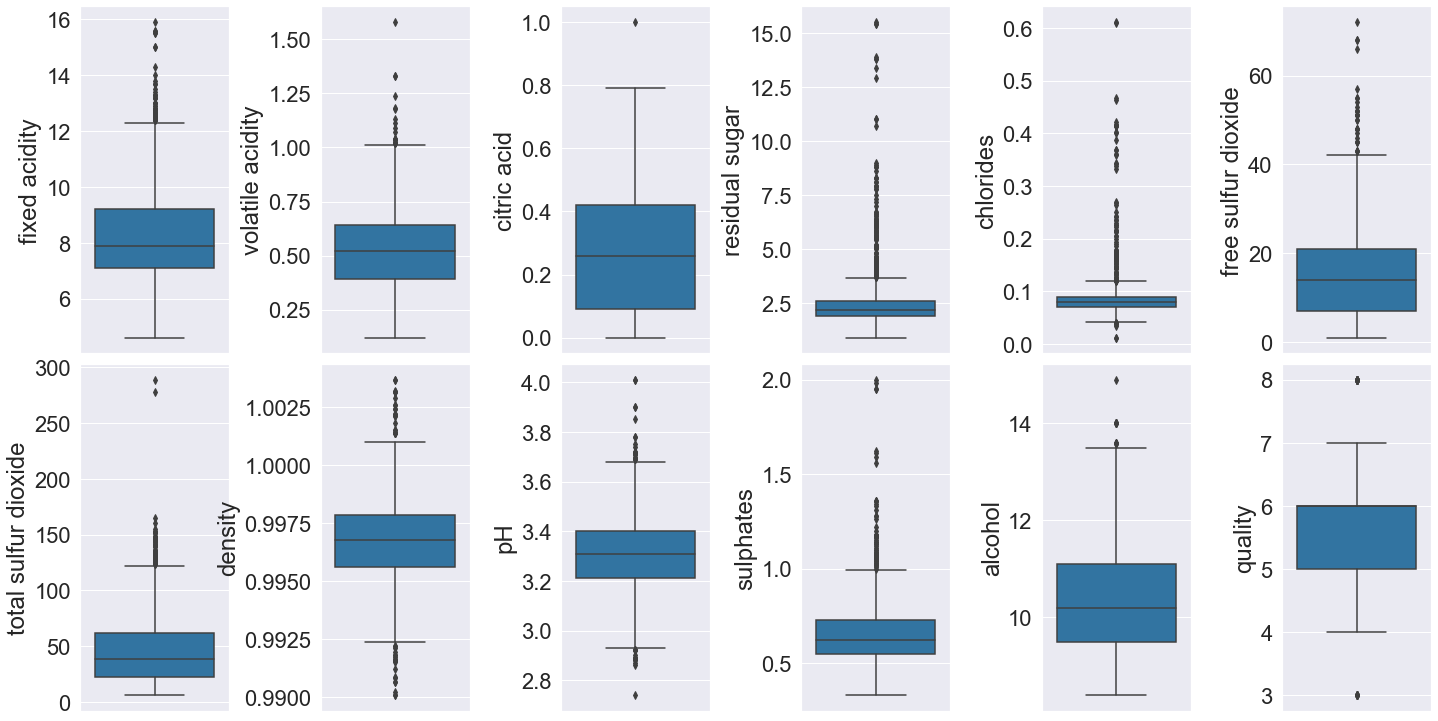

In [218]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.boxplot(y=col, data=data, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

Dažiem (piem. "total sulfur dioxide") ir tādas vērtības. Varbūt tie ietekmēs precizitāti.

Paskatīsimies uz vērtību sadali.

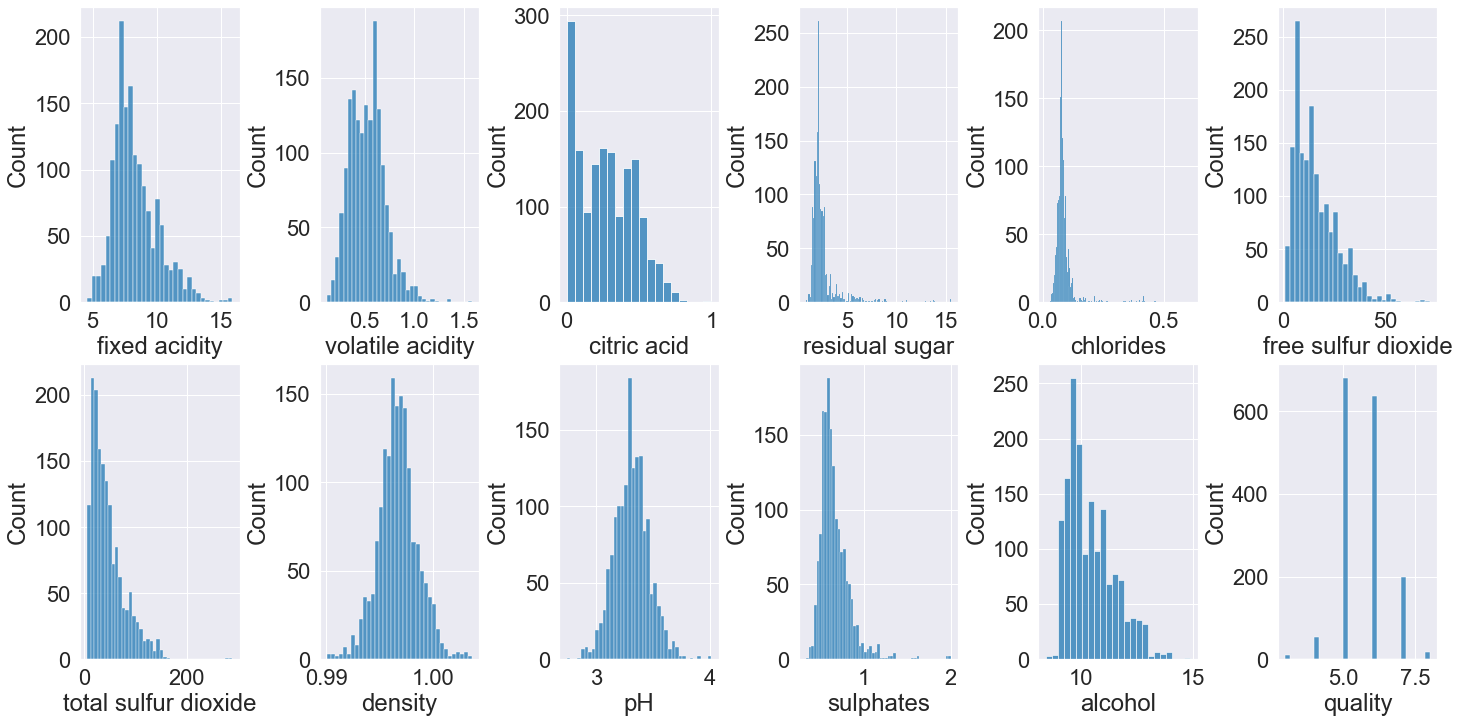

In [219]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.histplot(value, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

<AxesSubplot:xlabel='quality', ylabel='count'>

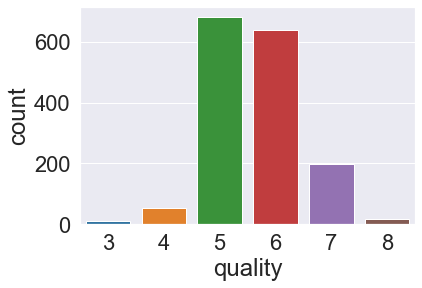

In [220]:
sns.countplot(x=data['quality'])

Bet "quality" gan ir cita lieta - mums pārsvārā ir vērtības 5,6 un pat nav dažu vērtību vispār. Tāda klašu nelīdzsvarotība nozīmē, ka modelis varēs labi noklasificēt tikai 5. un 6. kvalitātes gadījumus. Tātad datus būs janobalansē.

### Paramtetru korelācija

<AxesSubplot:>

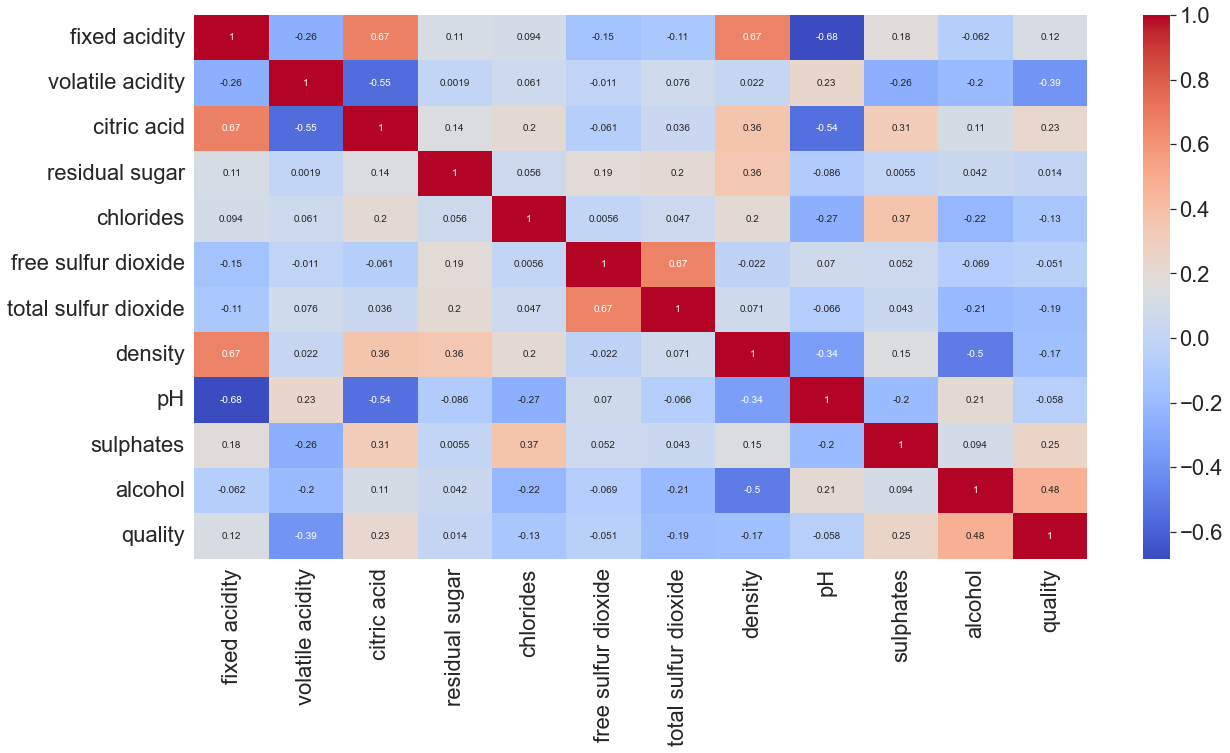

In [221]:
corr = data.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')

Te ir redzams, ka "alcohol" ietekmē kvalitāti visvairāk, tātad tas ir svārīgs parametrs. Vēl alkohols korelē ar blīvumu (density), tas nozīmē, ka varam atstāt tikai vienu. Tas pats attiecas uz "free"/"total" sulfur dioxide, un dažu veidu skābumi (acidity). Ja būs problēmas ar precizitāti - varbūt noņemšu tos.

## Datu sadalīšana apmācības un pārbaudes kopās

In [222]:
samples = data.copy()
samples.pop('free sulfur dioxide')
samples.pop('citric acid')
qualities = samples.pop('quality')

### Klašu vērtību balansēšana

In [223]:
qualities.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [224]:
oversample = SMOTE()
samples, qualities = oversample.fit_resample(samples, qualities)

In [225]:
qualities.value_counts()

5    681
6    681
7    681
4    681
8    681
3    681
Name: quality, dtype: int64

Dati tika sabalancēti.

In [226]:
samples_train, samples_test, qualities_train, qualities_test = train_test_split(samples, qualities, test_size=0.3, random_state=0)

In [234]:
def build_model(input_count: int, output_count: int):
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=42)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(1, kernel_initializer=init, activation='relu', input_shape=(input_count, )))
    # model.add(tf.keras.layers.Dense(1, activation='relu'))

    adam = tf.keras.optimizers.Adam(learning_rate=0.0005)

    model.compile(loss='mse', optimizer=adam, metrics=['mae', 'mse'])

    return model

In [235]:
attr_count = len(samples.keys())
print(attr_count, len(qualities.value_counts()))

9 6


Mums ir 11 atribūti un 6 klases, jo nav datu priekš citām klasēm.
Tagad uzbūvēsim modeli un trenēsim to:

In [ ]:
model = build_model(attr_count, 1)
history = model.fit(samples_train, qualities_train, validation_data=(samples_test, qualities_test), shuffle=False, epochs=5000, verbose=0)

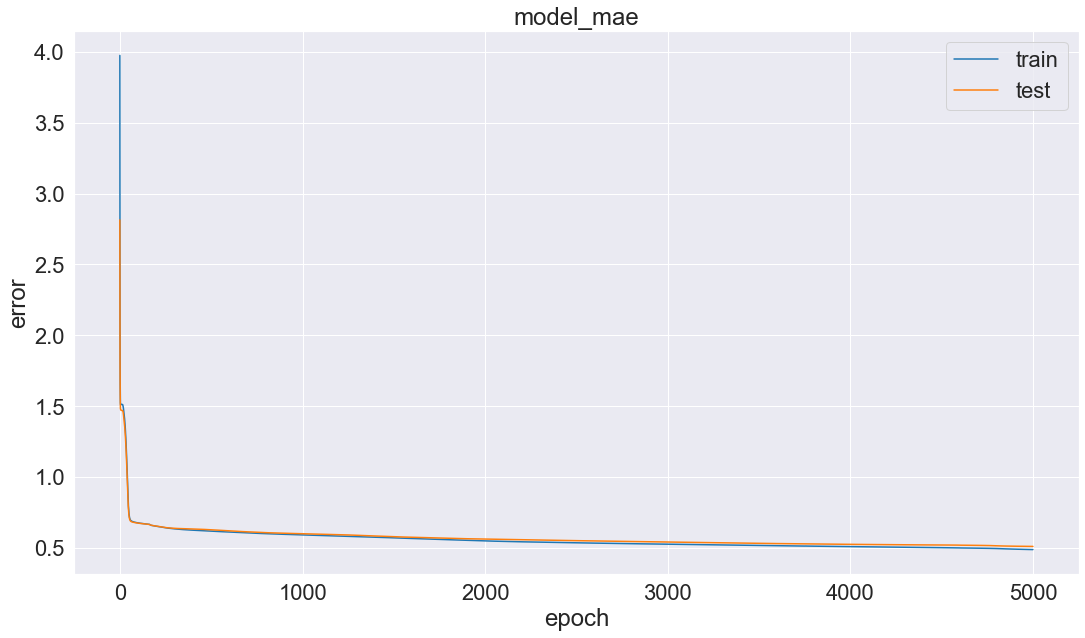

In [230]:
plt.figure(figsize=(18, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model_mae')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

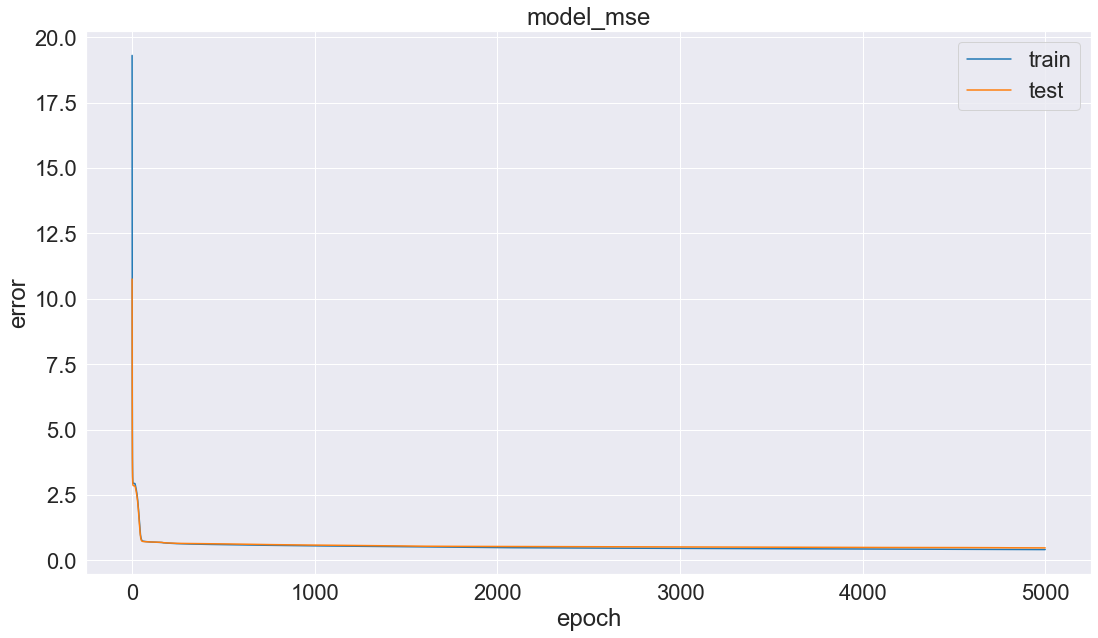

In [231]:
plt.figure(figsize=(18, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model_mse')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [232]:
result = model.predict(samples_test)

In [233]:
sample_idx = -20
print(f'Predicted: {result[sample_idx][0]}, Expected: {qualities_test.iat[sample_idx]}')
print(samples_test.iloc[sample_idx])

Predicted: 7.456177234649658, Expected: 7
fixed acidity            9.099513
volatile acidity         0.300060
residual sugar           1.999930
chlorides                0.064000
total sulfur dioxide    24.999768
density                  0.995160
pH                       3.260042
sulphates                0.839963
alcohol                 11.699733
Name: 3020, dtype: float64
